Load Data

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import os
import glob
import numpy as np
from sklearn.cluster import SpectralClustering

result_dir = '../results'
tasks = ['co_smooth', 'inter_region', 'intra_region']
bin_size = 0.02 # 20 ms
colormap = 'magma'
# get all gt.npy files under result_dir
gt_file = glob.glob(os.path.join(result_dir, '**/gt.npy'), recursive=True)[0]
gt_result = np.load(gt_file)
print(gt_result.shape)
temporal_result_paths = glob.glob(os.path.join(
    result_dir, 
    'eval', 
    'num_session_1', 
    '**/mask_temporal', 
    '**/pred.npy'), recursive=True)

# filder out the temporal result
temporal_result_paths = [result for result in temporal_result_paths if any(task in result for task in tasks)]

mtm_result_paths = glob.glob(os.path.join(
    result_dir, 
    'eval', 
    'num_session_1', 
    '**/mask_all', 
    '**/pred.npy'), recursive=True)
# filter out the mtm result
mtm_result_paths = [result for result in mtm_result_paths if any(task in result for task in tasks)]
print(len(temporal_result_paths), len(mtm_result_paths))


clustering = SpectralClustering(n_clusters=2, 
                                n_neighbors=5,
                                affinity='nearest_neighbors',
                                assign_labels='discretize',
                                random_state=0)
neuron_range = {"start": 26, "end": 52}
                
gt_result = gt_result.mean(0)[:, neuron_range["start"]:neuron_range["end"]]
clustering = clustering.fit(gt_result.T)
t_sort = np.argsort(clustering.labels_)
print(t_sort)
gt_mean = gt_result / bin_size

(27, 30, 130)
3 3
[25 23 22 19 17  8  9 16 14 13 21 20 18 15  0 11 10  7  6  5  4  3  2  1
 24 12]


Intra-Region

['../results/eval/num_session_1/model_NDT1/method_ssl/mask_all/stitch_True/nlb-rtt/intra_region/pred.npy']
['../results/eval/num_session_1/model_NDT1/method_ssl/mask_temporal/stitch_True/nlb-rtt/intra_region/pred.npy']


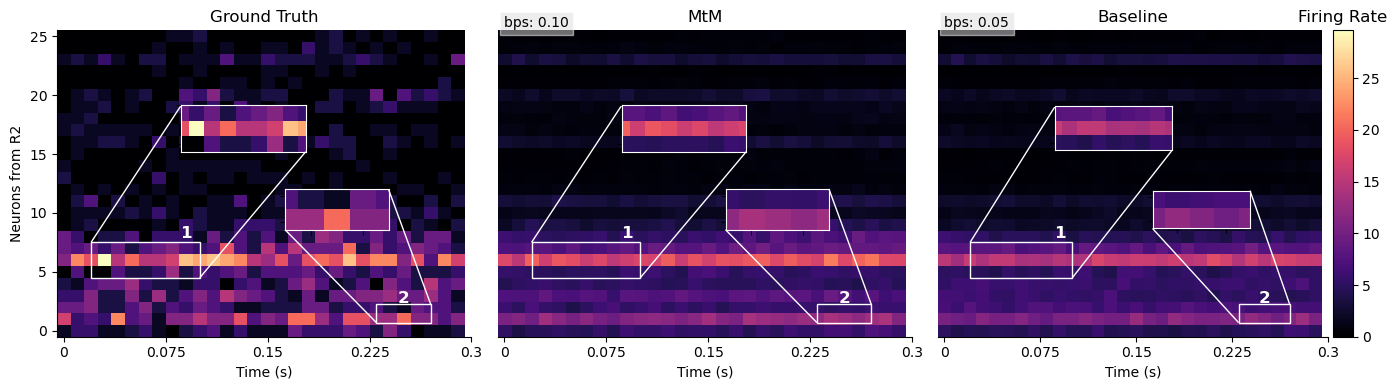

In [144]:
# get the temporal result that inter_region in the path
temporal_result_path = [result for result in temporal_result_paths if 'intra_region' in result]
# get the mtm result that inter_region in the path
mtm_result_path = [result for result in mtm_result_paths if 'intra_region' in result]
# load the temporal result
temporal_result = np.load(temporal_result_path[0])
temporal_mean = temporal_result.mean(0) / bin_size
temporal_mean = temporal_mean[:,neuron_range["start"]:neuron_range["end"]]

# load the mtm result
mtm_result = np.load(mtm_result_path[0])
print(mtm_result_path)
print(temporal_result_path)
mtm_mean = mtm_result.mean(0) / bin_size
mtm_mean = mtm_mean[:,neuron_range["start"]:neuron_range["end"]]

display = [gt_mean.T[t_sort], mtm_mean.T[t_sort], temporal_mean.T[t_sort]]
minmin = np.min([np.min(gt_mean), np.min(temporal_mean), np.min(mtm_mean)])
maxmax = np.max([np.max(gt_mean), np.max(temporal_mean), np.max(mtm_mean)])

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
divider = make_axes_locatable(axes[2])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
im1 = axes[0].imshow(display[0], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im2 = axes[1].imshow(display[1], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
im3 = axes[2].imshow(display[2], aspect='auto', cmap=colormap, vmin=minmin, vmax=maxmax, origin='lower')
plt.colorbar(im1, cax=cbar_ax)
cbar_ax.set_title('Firing Rate')
axes[0].set_title('Ground Truth')
axes[2].set_title('Baseline') # (bps: -0.29)
axes[1].set_title('MtM') # bps: 0.39
axes[0].set_ylabel('Neurons from R2')
for i, ax in enumerate(axes):
    ax.set_xticks([0, 7.5, 15, 22.5, 30], [0, 0.075, 0.15, 0.225, 0.3])
    ax.set_xlabel('Time (s)')
    if i == 0:
        ax.spines[['right', 'top']].set_visible(False)
    else:
        ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.set_yticks([],[])

axes[2].text(0, 25.75, 'bps: 0.05', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))
axes[1].text(0, 25.75, 'bps: 0.10', bbox=dict(boxstyle="square",
                   ec='white',
                   fc='gainsboro',
                   alpha=.5
                   ))
for i, ax in enumerate(axes):
    # small box to show the zoomed in region
    x1, x2, y1, y2 = 2, 10, 4.5, 7.5
    # draw a rectangle in the main axes
    # left, bottom, width, height
    axins = ax.inset_axes(
        [0.3, 0.53, 0.30, 0.30],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.imshow(display[i], origin='lower', cmap=colormap, vmin=minmin, vmax=maxmax)
    axins.spines['bottom'].set_color('white')
    axins.spines['top'].set_color('white') 
    axins.spines['right'].set_color('white')
    axins.spines['left'].set_color('white')
    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="1")
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='white', facecolor='none')
    # ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2 + 3
    cy = ry + rect.get_height() * 1.25
    ax.annotate('1', (cx, cy), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')
    ax.annotate('1', (44, 13), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')
    
for i, ax in enumerate(axes):
    x1, x2, y1, y2 = 23, 27, 0.7, 2.25
    axins = ax.inset_axes(
        # [0.02, 0.55, 0.2, 0.2],
        [0.55, 0.30, .25, .23],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.imshow(display[i], origin='lower', cmap=colormap, vmin=minmin, vmax=maxmax)
    axins.spines['bottom'].set_color('white')
    axins.spines['top'].set_color('white') 
    axins.spines['right'].set_color('white')
    axins.spines['left'].set_color('white')
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="1", linestyle='-')
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='white', facecolor='none')
    # ax.add_patch(rect)
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width() / 2 
    cy = ry + rect.get_height() * 1.3
    ax.annotate('2', (cx, cy), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')
    ax.annotate('2', (93, 17), color='w', weight='bold', 
                fontsize=12, ha='center', va='center')
    

plt.tight_layout()